In [58]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import plotly as ply
import seaborn as sns

In [59]:
pathMain = 'API_19_DS2_en_excel_v2_6002116.xls'
pathGDP =  "API_NY.GDP.MKTP.CD_DS2_en_excel_v2_5994847.xls"
pathGDPcap = "API_NY.GDP.PCAP.CD_DS2_en_excel_v2_5994922.xls"

In [60]:
def dataInitialize(mainData,GDPdir,GDPCapDir): 

    #Reads the data file and takes out all the sheets from it
    dfData = pd.read_excel(mainData, header=3)
    dfGDP = pd.read_excel(GDPdir, header=3)
    dfGDPcap = pd.read_excel(GDPCapDir, header=3)
    dfCountryMetaData = pd.read_excel(mainData, sheet_name= 'Metadata - Countries')
    dfIndicatorMetaData = pd.read_excel(mainData, sheet_name= 'Metadata - Indicators')

    #Merged columns from Data and Country MetaData
    dfDataMerged = pd.merge(dfData, dfCountryMetaData, on='Country Code', how='inner')
    dfDataMerged = pd.concat([dfDataMerged,dfGDP,dfGDPcap],axis=0).sort_values(by='Country Name', ascending=True)
    dfDataMerged = dfDataMerged.reset_index()

    #Filling in NaN Regions and IncomeGroups with respective values
    region_list={}
    income_list={}
    for i in dfCountryMetaData['TableName'].unique():
        region_list[i] = dfCountryMetaData[dfCountryMetaData['TableName']==i]['Region'].unique()[0]
        income_list[i] = dfCountryMetaData[dfCountryMetaData['TableName']==i]['IncomeGroup'].unique()[0]

    for i,j in region_list.items():
        dfDataMerged.loc[dfDataMerged['Country Name'] == i,'Region'] = j
        dfDataMerged.loc[dfDataMerged['Country Name'] == i,'IncomeGroup'] = j
    # dfDataMerged

    #Sorting Columns out, changing column positions to start of df and removing unwanted columns
    columnslist = dfDataMerged.columns.tolist()
    columnslist.insert(4,columnslist.pop(dfDataMerged.columns.get_loc('Region')))
    columnslist.insert(5,columnslist.pop(dfDataMerged.columns.get_loc('IncomeGroup')))
    dfDataMerged = dfDataMerged[columnslist]
    dfDataMerged = dfDataMerged.drop(columns=['SpecialNotes', 'TableName','index'], axis=1)
    # dfDataMerged

    #Setting Multilevel Index for df (dfCountry)
    dfCountry = dfDataMerged.set_index(['Country Name','Country Code','Region','IncomeGroup','Indicator Code','Indicator Name'])

    #Filtering out columns based on Indicators I want to look at. Filter Indicators and Countries here.
    dfCountry = dfCountry[dfCountry.index.get_level_values('Indicator Code').isin(['SP.POP.TOTL','SP.POP.GROW','SP.URB.TOTL.IN.ZS','NV.AGR.TOTL.ZS','EN.ATM.GHGT.ZG','EN.ATM.GHGT.KT.CE','EG.USE.PCAP.KG.OE','EG.USE.ELEC.KH.PC','EG.ELC.PETR.ZS','EG.ELC.NGAS.ZS','EG.ELC.COAL.ZS','EG.ELC.ACCS.ZS','AG.LND.FRST.ZS','AG.LND.FRST.K2','AG.LND.AGRI.ZS','NY.GDP.MKTP.CD','NY.GDP.PCAP.CD'])]
    dfCountry = dfCountry[dfCountry.index.get_level_values('Country Name').isin(['India','China','Bangladesh','Australia','New Zealand','Nigeria','Egypt, Arab Rep.','South Africa','Brazil','Colombia','Argentina','Canada','United States','Germany','Spain','Austria'])]

    #This is where the function to output two dataframes ends
    dfYear = dfCountry.T
    
    return dfCountry,dfYear

In [61]:
dfCountry, dfYear = dataInitialize(pathMain,pathGDP,pathGDPcap)

In [62]:
#Creating TimeSeries for 'GDP (current US$)'. Here I create a sub df (dfTimeSeries) using the dfCountry output from the function
rowLabels =  pd.IndexSlice[:,:,:,:,('NY.GDP.MKTP.CD'),:] 
dfTimeSeries = dfCountry.loc[rowLabels, :]

In [63]:
dfTimeSeries = dfTimeSeries.reset_index()

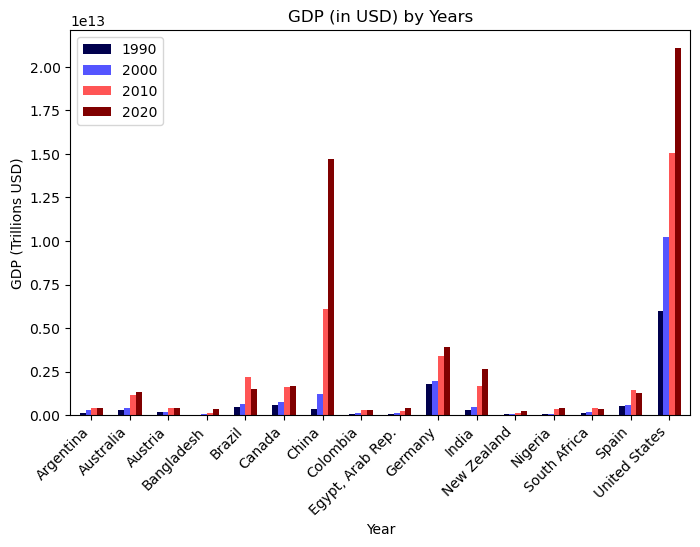

In [89]:
#plot for GDP for each country by years

dfGDP = pd.melt(dfTimeSeries,id_vars=['Country Name','Indicator Name'],value_vars=[str(x) for x in range(1990,2021,10)])
dfGDP.pivot(index='Country Name',columns='variable',values='value').plot(kind='bar',width=0.6,figsize=(8,5),colormap='seismic' )

plt.xlabel('Year')
plt.ylabel('GDP (Trillions USD)')
plt.title('GDP (in USD) by Years')
plt.xticks(rotation=45, ha='right')

plt.legend()
# plt.grid(True)
plt.show()


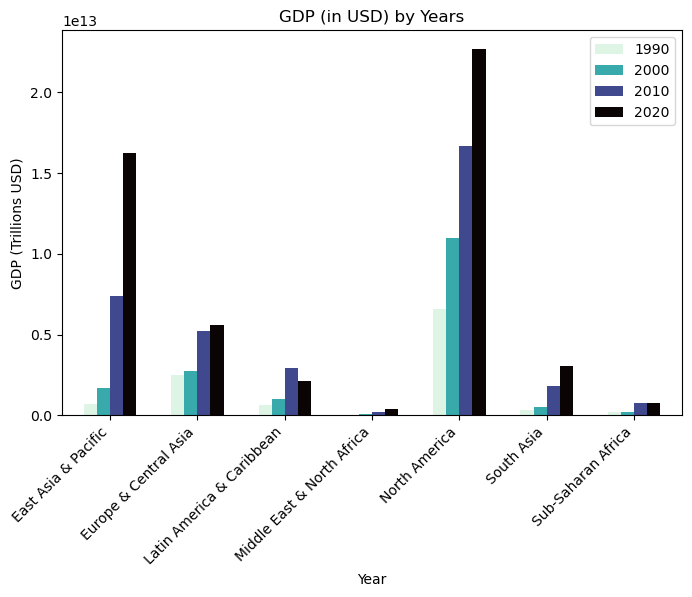

In [88]:
#plot for GDP for Regions by years

dfGDPregion = pd.melt(dfTimeSeries,id_vars=['Region','Indicator Name'],value_vars=[str(x) for x in range(1990,2021,10)])
dfGDPregion = dfGDPregion.groupby(['Region','variable'])['value'].sum().reset_index()
defs = dfGDPregion.pivot(index='Region',columns='variable',values='value').plot(kind='bar',width=0.6,figsize=(8,5),colormap='mako_r')

plt.xlabel('Year')
plt.ylabel('GDP (Trillions USD)')
plt.title('GDP (in USD) by Years')
plt.xticks(rotation=45, ha='right')

plt.legend()
# plt.grid(True)
plt.show()


In [66]:
#NEW SECTION -- CREATING NEW VISUALIZATIONS FOR THE REST OF THE PAPER
  
dfPopulationTotal = dfCountry.loc[pd.IndexSlice[:,:,:,:,('SP.POP.TOTL'),:], :]
   
dfPopulationGrowth = dfCountry.loc[pd.IndexSlice[:,:,:,:,('SP.POP.GROW'),:], :]

dfUrbanPopulation = dfCountry.loc[pd.IndexSlice[:,:,:,:,('SP.URB.TOTL.IN.ZS'),:], :]

dfGDPCapita = dfCountry.loc[pd.IndexSlice[:,:,:,:,('NY.GDP.PCAP.CD'),:], :]

dfEnergy = dfCountry.loc[pd.IndexSlice[:,:,:,:,('EG.USE.ELEC.KH.PC'),:], :]

dfEnergySources = dfCountry.loc[pd.IndexSlice[('United States','China','India','Nigeria','Bangladesh'),:,:,:,('EG.ELC.PETR.ZS','EG.ELC.NGAS.ZS','EG.ELC.COAL.ZS'),:], :]  

dfForestLand = dfCountry.loc[pd.IndexSlice[:,:,:,:,('AG.LND.FRST.K2'),:], :]  

dfgreenhouse = dfCountry.loc[pd.IndexSlice[:,:,:,:,('EN.ATM.GHGT.KT.CE'),:], :]  


In [67]:
dfPopulationTotal = dfPopulationTotal.reset_index()
dfPopulationGrowth = dfPopulationGrowth.reset_index()
dfUrbanPopulation = dfUrbanPopulation.reset_index()
dfGDPCapita.reset_index(inplace=True)
dfEnergy.reset_index(inplace=True)
dfEnergySources.reset_index(inplace=True)
dfgreenhouse.reset_index(inplace=True)
dfForestLand.reset_index(inplace=True)

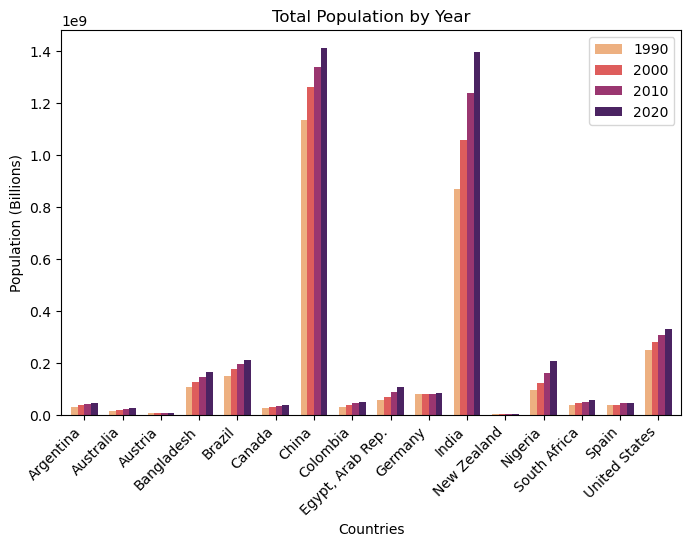

In [90]:
#plot for GDP for Countries by years

dfPopTotal = pd.melt(dfPopulationTotal,id_vars=['Country Name','Indicator Name'],value_vars=[str(x) for x in range(1990,2021,10)])
# dfPopGrowth = dfPopGrowth.groupby(['Country Name','variable'])['value'].sum().reset_index()
dfPopTotal.pivot(index=['Country Name'],columns='variable',values='value').plot(kind='bar',width=0.7,figsize=(8,5),colormap='flare')

plt.xlabel('Countries')
plt.ylabel('Population (Billions)')
plt.title('Total Population by Year')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

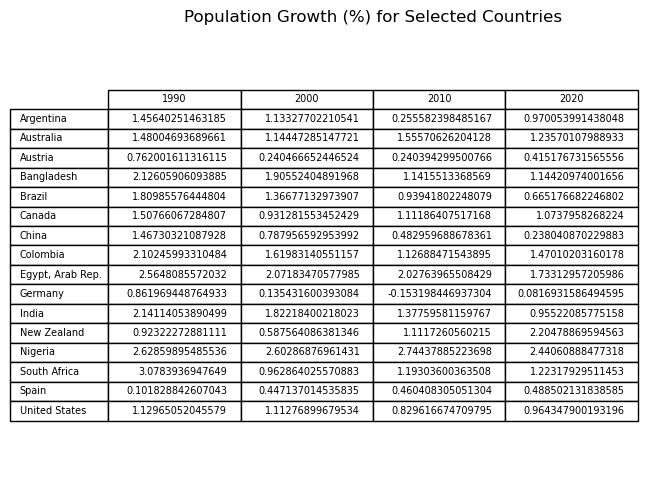

In [69]:
dfPopGrowth = pd.melt(dfPopulationGrowth,id_vars=['Country Name','Indicator Name'],value_vars=[str(x) for x in range(1990,2021,10)])
PopGrowthPivot = dfPopGrowth.pivot_table(index='Country Name',columns='variable',values='value')

fig, ax = plt.subplots(figsize=(7, 5))
ax.table(cellText=PopGrowthPivot.values, colLabels=PopGrowthPivot.columns, rowLabels=PopGrowthPivot.index, loc='center')

ax.set_title('Population Growth (%) for Selected Countries')
ax.set_axis_off()
plt.tight_layout()

plt.show()

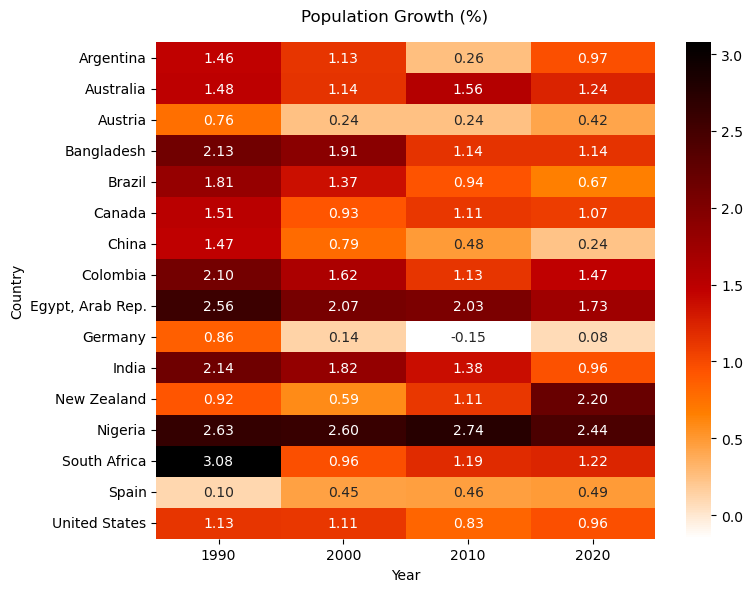

In [70]:
dfPopGrowth = pd.melt(dfPopulationGrowth,id_vars=['Country Name','Indicator Name'],value_vars=[str(x) for x in range(1990,2021,10)])
PopGrowthPivot = dfPopGrowth.pivot_table(index='Country Name',columns='variable',values='value')

fig, axs = plt.subplots(figsize=(8,6))
sns.heatmap(PopGrowthPivot, annot=True, fmt=".2f", cmap="gist_heat_r")

plt.suptitle('Population Growth (%)')
# axs.set_title('Heatmap')
axs.set_xlabel('Year')
axs.set_ylabel('Country')
plt.tight_layout()
plt.show()

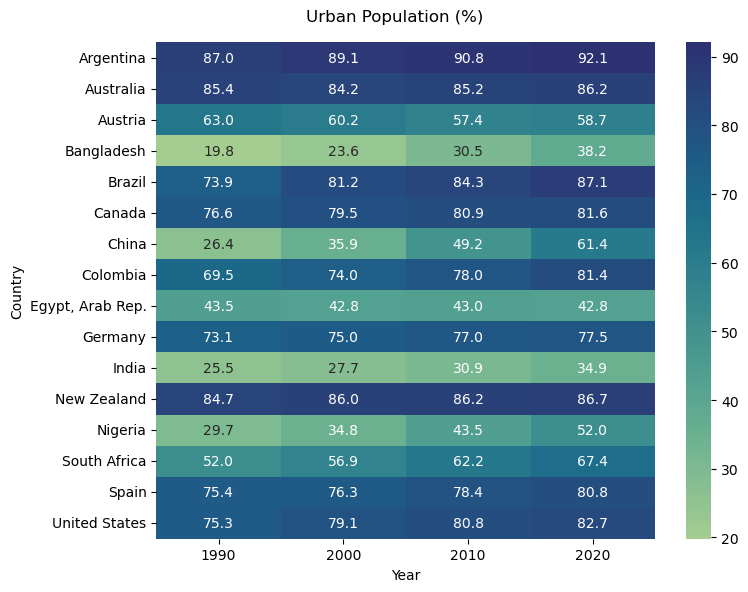

In [71]:
dfUrbPop = pd.melt(dfUrbanPopulation,id_vars=['Country Name','Indicator Name'],value_vars=[str(x) for x in range(1990,2021,10)])
UrbPopPivot = dfUrbPop.pivot_table(index='Country Name',columns='variable',values='value')

fig, axs = plt.subplots(figsize=(8, 6))
sns.heatmap(UrbPopPivot, annot=True, fmt=".1f", cmap="crest")

plt.suptitle('Urban Population (%)')
# axs.set_title('Heatmap')
axs.set_xlabel('Year')
axs.set_ylabel('Country')
plt.tight_layout()
plt.show()


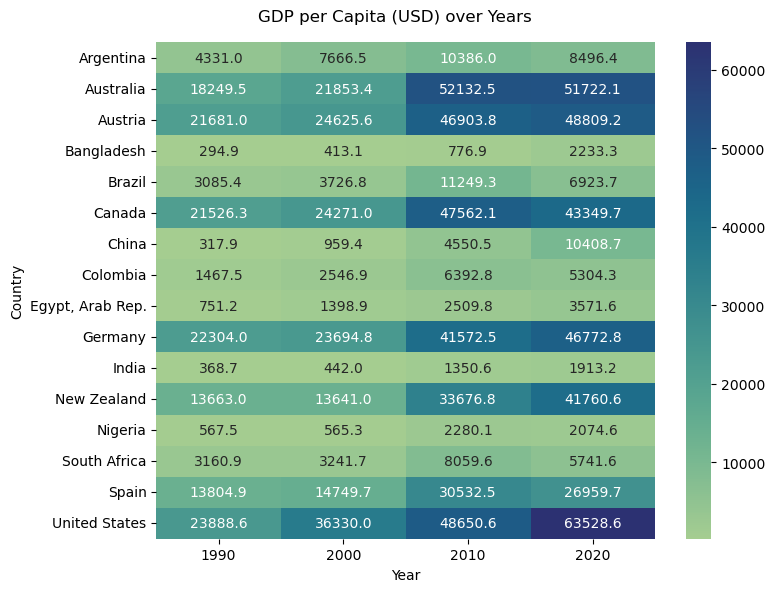

In [72]:
dfGDPcap = pd.melt(dfGDPCapita,id_vars=['Country Name','Indicator Name'],value_vars=[str(x) for x in range(1990,2021,10)])
GDPCapPivot = dfGDPcap.pivot_table(index='Country Name',columns='variable',values='value')

fig, axs = plt.subplots(figsize=(8, 6))
sns.heatmap(GDPCapPivot, annot=True, fmt=".1f", cmap="crest")

plt.suptitle('GDP per Capita (USD) over Years')
# axs.set_title('Heatmap')
axs.set_xlabel('Year')
axs.set_ylabel('Country')
plt.tight_layout()
plt.show()


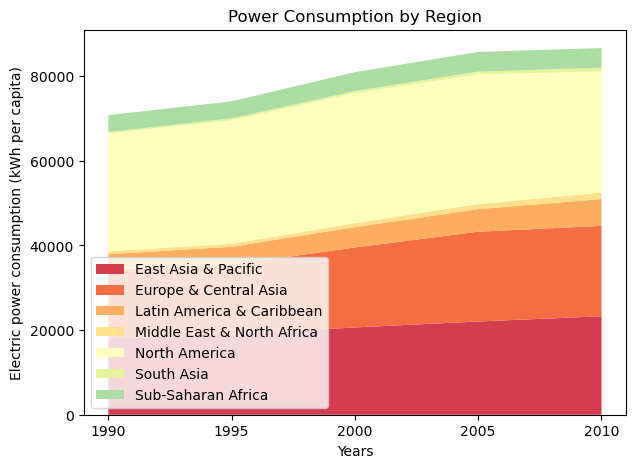

In [93]:
dfEnergyC = pd.melt(dfEnergy,id_vars=['Country Name','Indicator Name','Region'],value_vars=[str(x) for x in range(1990,2015,5)])
dfEnergyC = dfEnergyC.groupby(['Region','variable'])['value'].sum().reset_index()
EnergyPivot = dfEnergyC.pivot_table(index='Region',columns='variable',values='value')

plt.figure(figsize=(7,5))

years = EnergyPivot.columns
values = EnergyPivot.values
pallete = sns.color_palette('Spectral', 9)

plt.stackplot(years, values, labels=EnergyPivot.index, colors=pallete)

plt.xlabel('Years')
plt.ylabel('Electric power consumption (kWh per capita)')
plt.title('Power Consumption by Region')
plt.legend(loc='lower left')

plt.show()

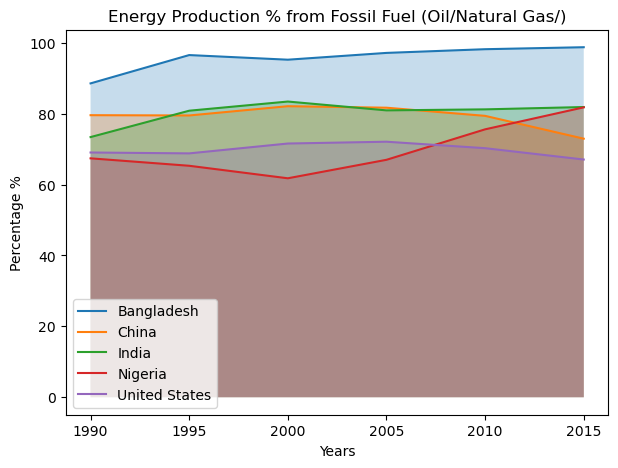

In [74]:
dfEnergySRC = pd.melt(dfEnergySources,id_vars=['Country Name','Indicator Name','Region'],value_vars=[str(x) for x in range(1990,2016,5)])
dfEnergySRC = dfEnergySRC.groupby(['Country Name','variable'])['value'].sum().reset_index()
EnergySRCPivot = dfEnergySRC.pivot_table(index='Country Name',columns='variable',values='value')

plt.figure(figsize=(7,5))

line_data = EnergySRCPivot.transpose()

for country in line_data.columns:
    plt.plot(line_data.index, line_data[country], label=country)
    plt.fill_between(line_data.index, line_data[country], alpha=0.25)

plt.xlabel('Years')
plt.ylabel('Percentage %')
plt.title('Energy Production % from Fossil Fuel (Oil/Natural Gas/)')
plt.legend() 

plt.show()


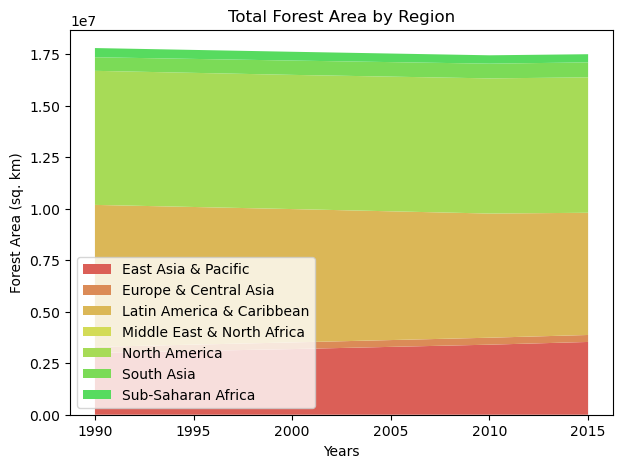

In [75]:
dfForest = pd.melt(dfForestLand,id_vars=['Country Name','Indicator Name','Region'],value_vars=[str(x) for x in range(1990,2016,5)])
dfForest = dfForest.groupby(['Region','variable'])['value'].sum().reset_index()
forestPivot = dfForest.pivot_table(index='Region',columns='variable',values='value')

plt.figure(figsize=(7,5))

years = forestPivot.columns
values = forestPivot.values

pallete = sns.color_palette('hls', 18)

plt.stackplot(years, values, labels=EnergyPivot.index,colors=pallete)

plt.xlabel('Years')
plt.ylabel('Forest Area (sq. km)')
plt.title('Total Forest Area by Region')
plt.legend(loc='lower left')

plt.show()


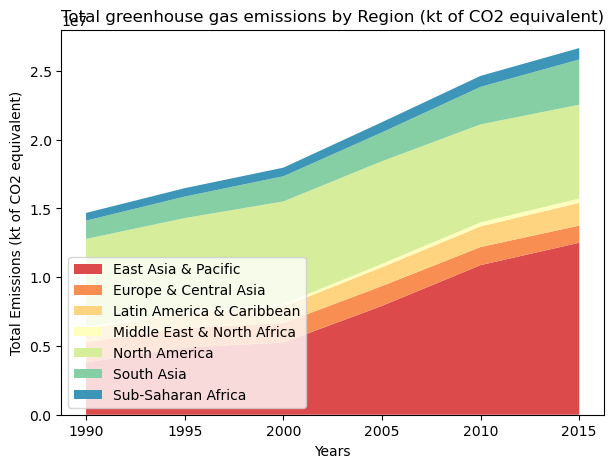

In [76]:
dfGHG = pd.melt(dfgreenhouse,id_vars=['Country Name','Indicator Name','Region'],value_vars=[str(x) for x in range(1990,2016,5)])
dfGHG = dfGHG.groupby(['Region','variable'])['value'].sum().reset_index()
GHGPivot = dfGHG.pivot_table(index='Region',columns='variable',values='value')

plt.figure(figsize=(7,5))

years = GHGPivot.columns
values = GHGPivot.values

pallete = sns.color_palette('Spectral', 7)

plt.stackplot(years, values, labels=EnergyPivot.index, colors=pallete)

plt.xlabel('Years')
plt.ylabel('Total Emissions (kt of CO2 equivalent)')
plt.title('Total greenhouse gas emissions by Region (kt of CO2 equivalent)')
plt.legend(loc='lower left')

plt.show()
